<a href="https://colab.research.google.com/github/fabian-fuentes/System_Dynamics/blob/main/labs/L1/scr/Lab1_collapse_maya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ------------------------------------------------------------
# System Dynamics Toy Model: "Collapse of Civilizations"
# Author: Dr Edmundo Molina
# Description:
#   Minimal system-dynamics model coupling land use, soil fertility,
#   food production, and population dynamics with migration feedback.
#   Implemented with deSolve::ode using a 4th-order Runge–Kutta (rk4).
# ------------------------------------------------------------

In [2]:
# --- Dependencies ------------------------------------------------------------
install.packages("deSolve")  # <- run once if not installed
library(deSolve)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# --- Model Equations ---------------------------------------------------------
# State vector y(t) := [forest, agricultural.land, fertility.of.lands, population]
# Parameters p := [intensity, emigration.ratio, consumed.food.per.person, natural.increase.rate]
#
# Notation:
#   forest(t):                   forested land (arbitrary area units)
#   agricultural.land(t):        cropland area (same units as forest)
#   fertility.of.lands(t):       land fertility scalar (proxy for yield)
#   population(t):               population (persons)
#   intensity:                   scaling for how fast processes unfold (>1 reduces rates)
#   consumed.food.per.person:    kg/person/year (demand)
#   natural.increase.rate:       net natural growth rate of population (per year)
#   emigration.ratio:            share of unmet food demand converting to emigration
#
# Endogenous relationships:
#   food.produced = fertility.of.lands * agricultural.land
#   demand.for.food = consumed.food.per.person * population
#   gap = demand.for.food - food.produced  (positive => shortage)
#
# Flows (per year):
#   deforestation:
#       additional ag land created to close the food gap, bounded by forest/4 per year,
#       damped by 'intensity'
#   fertility.losses:
#       degradation increases nonlinearly with ag land pressure vs forest,
#       damped by 'intensity'
#   natural.population.increase = population * natural.increase.rate
#   emigration = (gap / consumed.food.per.person) * emigration.ratio
#
# State derivatives:
#   d(agricultural.land)/dt =  deforestation
#   d(forest)/dt             = -deforestation
#   d(fertility.of.lands)/dt = -fertility.losses
#   d(population)/dt         =  natural.population.increase - emigration
#


In [4]:
collapse.of.civilizations <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {

    # --- Algebraic (endogenous) variables -----------------------------------
    # Food supply vs demand
    food.produced     <- fertility.of.lands * agricultural.land
    demand.for.food   <- consumed.food.per.person * population
    gap               <- demand.for.food - food.produced  # >0 => shortage, <0 => surplus

    # --- Flow variables (rates per time unit) --------------------------------
    # Deforestation: expand cropland to reduce the food gap,
    # bounded by available forest/4 per year and scaled by 'intensity'
    deforestation <- min(
      gap / max(fertility.of.lands, 1),   # new ag land needed to close gap (avoid /0)
      forest / 4                          # cap: cannot clear more than 25% of remaining forest per year
    ) / intensity

    # Fertility losses: nonlinear degradation as ag land pressure rises relative to forest
    fertility.losses <- fertility.of.lands * min(2, (agricultural.land / forest)^1.5) / intensity

    # Demography: natural growth and migration driven by unmet demand
    natural.population.increase <- population * natural.increase.rate
    emigration <- (gap / consumed.food.per.person) * emigration.ratio

    # --- Differential equations (state dynamics) -----------------------------
    dagricultural.land   <-  deforestation
    dforest              <- -deforestation
    dfertility.of.lands  <- -fertility.losses
    dpopulation          <-  natural.population.increase - emigration

    # Return list: first element is derivatives in same order as 'state',
    # followed by any variables you want saved in output for diagnostics.
    list(
      c(dforest, dagricultural.land, dfertility.of.lands, dpopulation),
      deforestation     = deforestation,
      fertility.losses  = fertility.losses,
      food.produced     = food.produced,
      demand.for.food   = demand.for.food,
      gap               = gap,
      emigration        = emigration,
      pop.natural.inc   = natural.population.increase
    )
  })
}


In [5]:
# --- Parameters --------------------------------------------------------------
parameters <- c(
  intensity                 = 1.1,      # >1 slows processes (acts like an "inertia" / dilution factor)
  emigration.ratio          = 0.01,     # share of per-capita shortage triggering emigration
  consumed.food.per.person  = 110,      # kg per person per year (demand)
  natural.increase.rate     = (2^(1/408) - 1)  # ≈ growth rate doubling in 408 years
)

In [6]:
# --- Initial Conditions (state at t0) ----------------------------------------
InitialConditions <- c(
  forest              = 5000,     # area units
  agricultural.land   = 8,        # area units
  fertility.of.lands  = 5000000,  # yield scalar (units such that fertility*area ≈ kg/yr)
  population          = 100000    # persons
)

In [7]:
# --- Simulation horizon ------------------------------------------------------
# Times are in the same "year" units as the rates above.
# Negative start time simply means "1000 years before present" for storytelling.
times <- seq(
  from = -1000,   # start time
  to   =  2000,   # end time
  by   =  1       # step (years)
)

In [8]:
# --- Numerical integration method -------------------------------------------
# 'rk4' is explicit 4th-order Runge–Kutta (good for smooth ODEs; fixed step).
intg.method <- "rk4"

# --- Run simulation ----------------------------------------------------------
out <- ode(
  y     = InitialConditions,
  times = times,
  func  = collapse.of.civilizations,
  parms = parameters,
  method = intg.method
)

In [9]:
# Convert to data.frame for convenience
out <- data.frame(out)

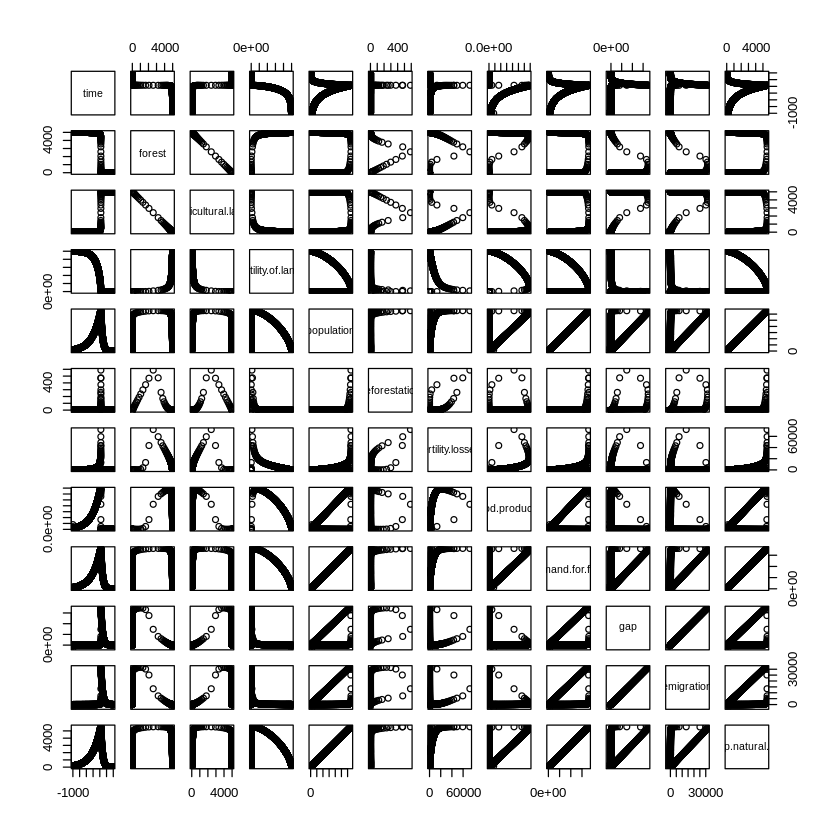

In [11]:
# --- Quick diagnostics / plots -----------------------------------
# Example: base plot to inspect trajectories
plot(out)


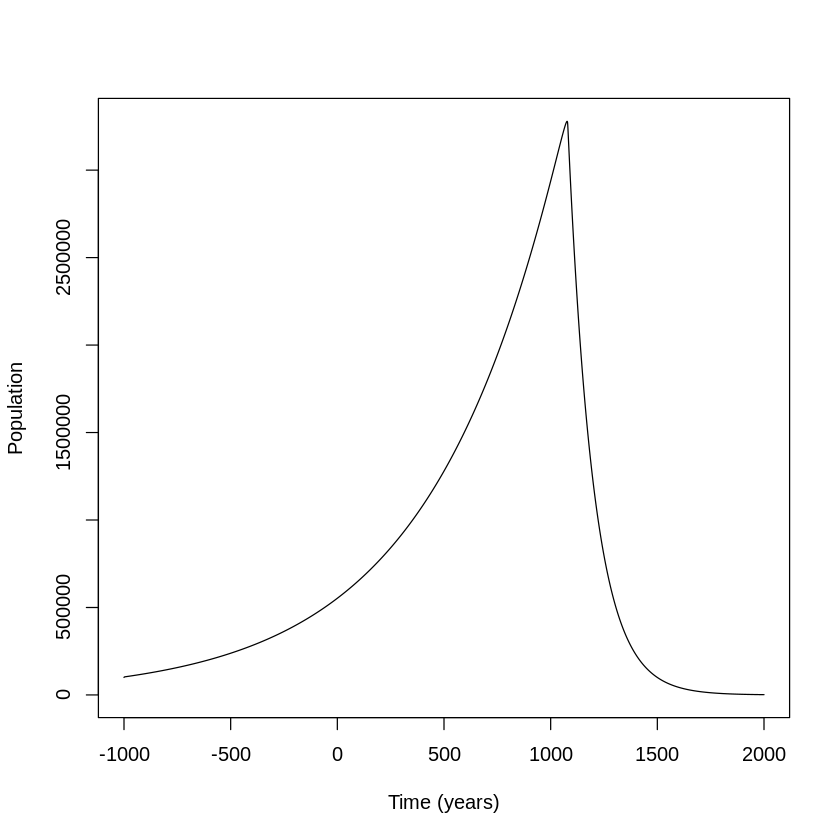

In [12]:
plot(out$time, out$population, type = "l", xlab = "Time (years)", ylab = "Population")

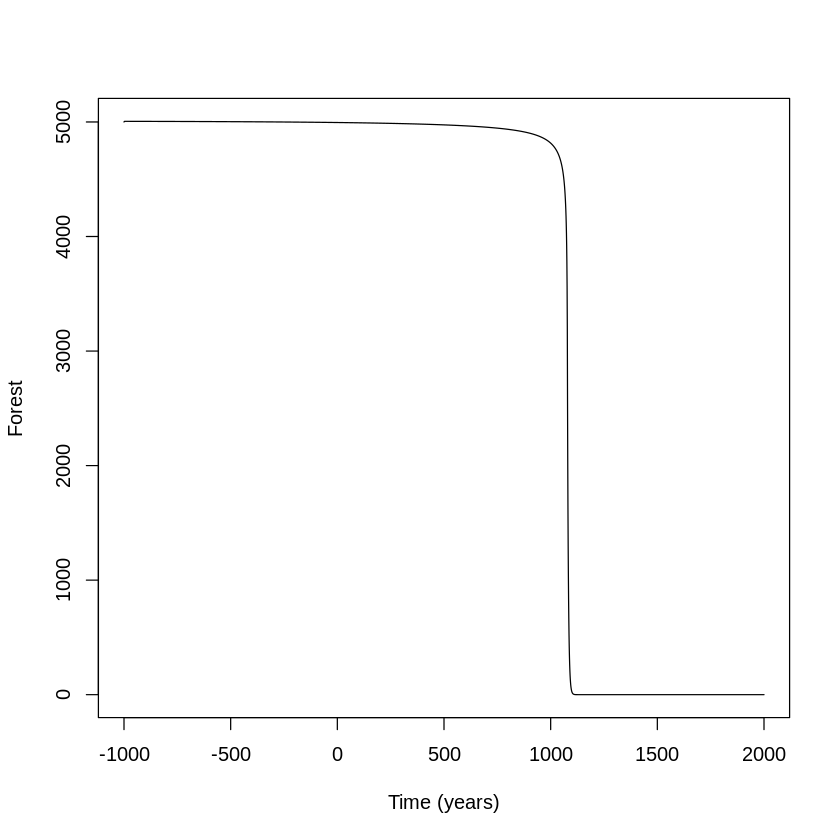

In [13]:
plot(out$time, out$forest, type = "l", xlab = "Time (years)", ylab = "Forest")


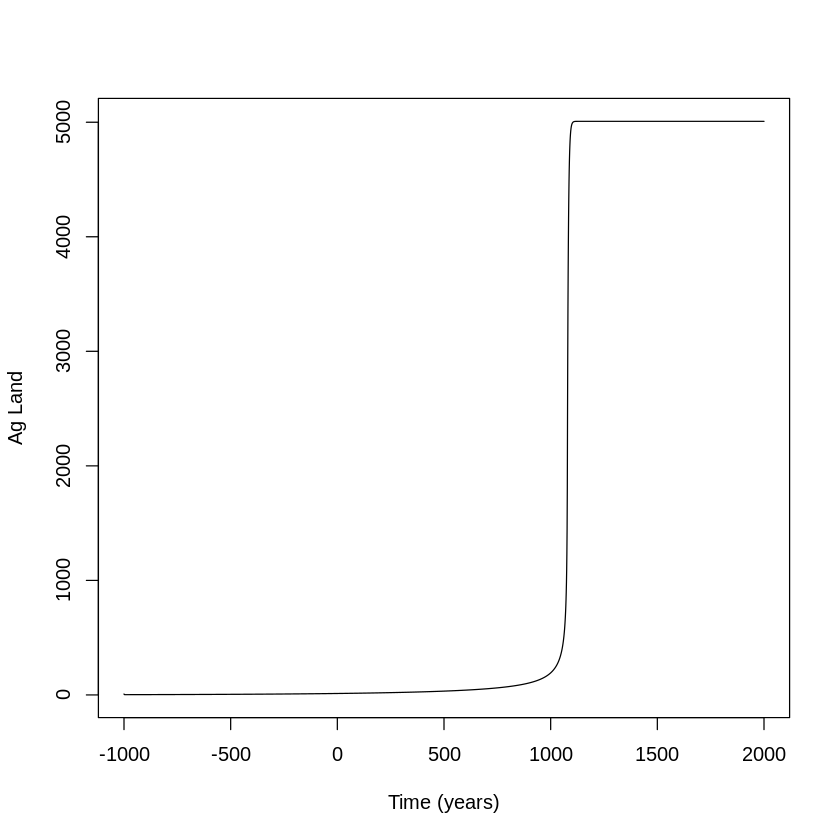

In [14]:
plot(out$time, out$agricultural.land, type = "l", xlab = "Time (years)", ylab = "Ag Land")

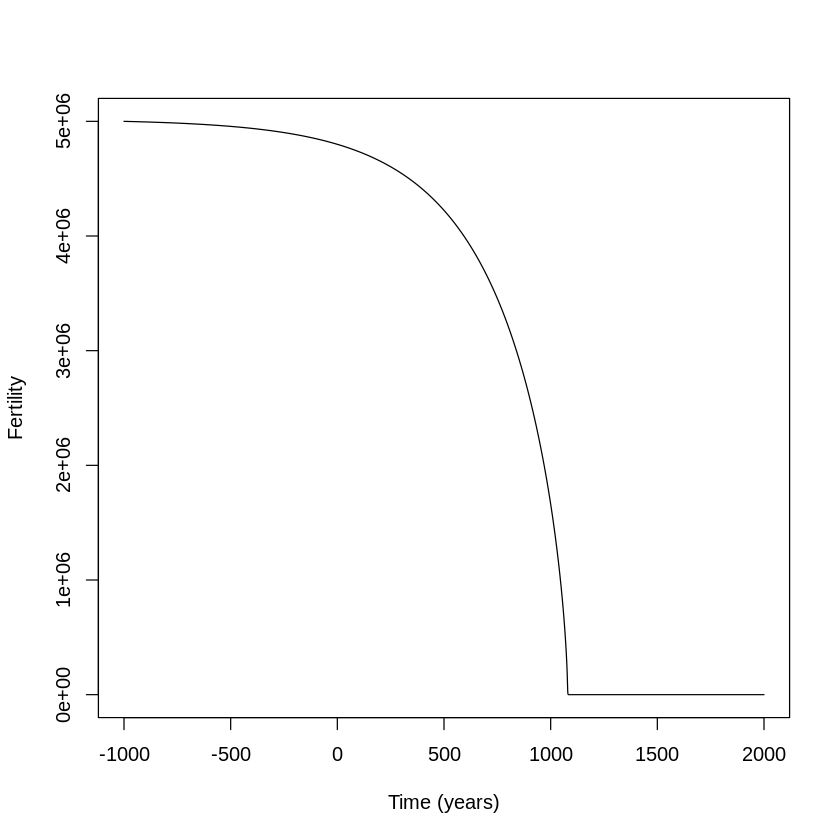

In [15]:
plot(out$time, out$fertility.of.lands, type = "l", xlab = "Time (years)", ylab = "Fertility")